In [1]:
import numpy as np
%matplotlib notebook
import pylab as plt
import pickle as pickle

import networkx as nx

from NAQ_graphs import NAQ

#for automatic graph generation
import yaml as yaml
from graph_generator import generate_graph
import os as os

<IPython.core.display.Javascript object>


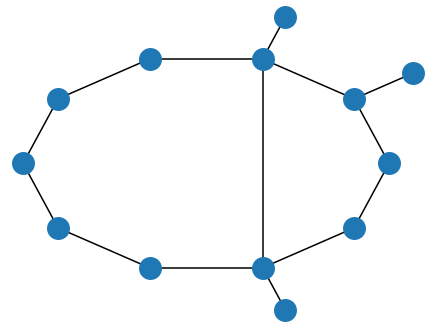

In [2]:
#create a small world network, using automatic generation, see generate_graph and graph_params for more

graph_tpe = 'SM'
params = yaml.load(open('graph_params.yaml','rb'))[graph_tpe]

G, pos  = generate_graph(tpe=graph_tpe, params = params)

if not os.path.isdir(graph_tpe):
    os.mkdir(graph_tpe)
os.chdir(graph_tpe)

#plot the graph
plt.figure(figsize=(4,3))
nx.draw(G, pos=pos, node_size=200)

In [3]:
#setup the main object
chi = np.array([ 1.j for i in range(len(G.edges))])

naq_u1 = NAQ(G, positions = pos, chi = chi, group = 'U1', open_graph = True)

naq_u1.n_processes_scan = 4 #number of CPU to use

#random update
naq_u1.update_chi([1.,1.])

#construct the graph laplacian
naq_u1.update_laplacian()

In [4]:
#load the modes found in test_NAQ_U1_open.ipynb
modes = pickle.load(open('modes.pkl', 'rb'))
Ks, Alphas, s = pickle.load( open('scan.pkl', 'rb'))

<IPython.core.display.Javascript object>


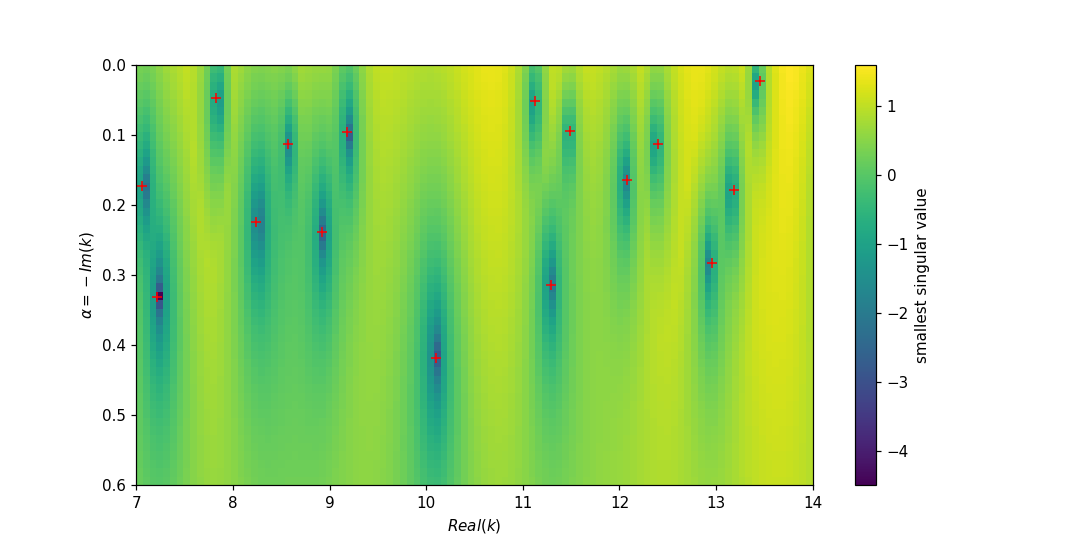

In [5]:
#plot the scan and modes
naq_u1.plot_scan(Ks,Alphas,s,modes)


In [6]:
#pump parameters (see SALT papers)
naq_u1.pump_params = {}
naq_u1.pump_params['gamma_perp'] = 1.
naq_u1.pump_params['k_a']        = 10.
naq_u1.pump_params['D0']         = 0 
naq_u1.pump_params['edges']      = [0, 1, 2, 3, 4, 5, 10]  #edges to pump

m = 0
naq_u1.update_chi(modes[m])
print("condition number no pump:", naq_u1.test_laplacian())

naq_u1.pump_params['D0']         = 1e-2
naq_u1.update_chi(modes[m])
print("condition number with pump:", naq_u1.test_laplacian())


condition number no pump: 9.79403e-06
condition number with pump: 0.20060097


In [7]:
#find the pump trajectories
params['s_size']    = 1e-2*np.asarray([1.,1.])

#the correct balaance between s_size and the D0 steps must be found for each graph/pump
D0_max = .1
D0_steps = 10

new_modes = naq_u1.pump_trajectories(modes, params, D0_max = D0_max, D0_steps = D0_steps)

D0: 0.011111111111111112
D0: 0.022222222222222223
D0: 0.03333333333333333
D0: 0.044444444444444446
D0: 0.05555555555555556
D0: 0.06666666666666667
D0: 0.07777777777777778
D0: 0.08888888888888889
D0: 0.1


<IPython.core.display.Javascript object>


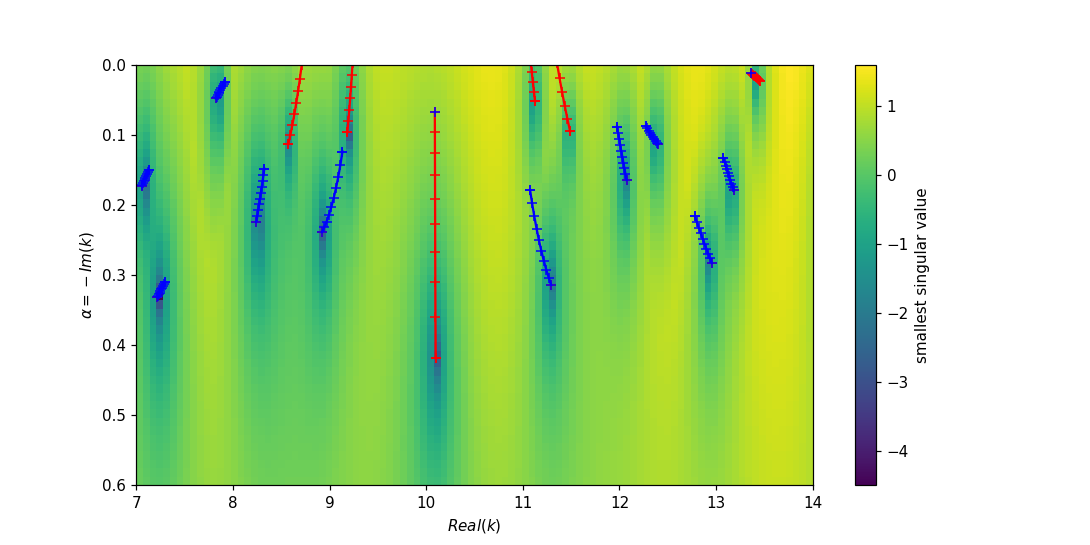

In [8]:
#plot the pump trajectories
naq_u1.plot_pump_traj(Ks, Alphas, s, modes, new_modes)

In [9]:
params['s_size']    = 5e-2*np.asarray([1.,1.])
params['max_steps'] = 2000
                        
th_modes, D0_th = naq_u1.full_lasing_threshold(modes, params, tol = 1e-4, D0_max = D0_max, D0_steps = D0_steps)

100%|██████████| 18/18 [00:51<00:00,  5.83s/it]


<IPython.core.display.Javascript object>


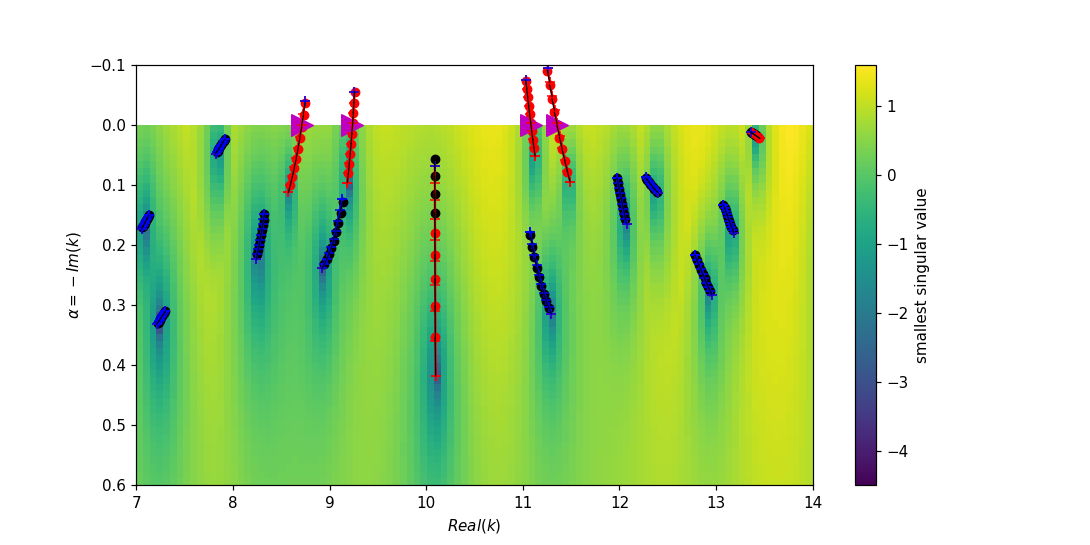

In [10]:
#plot the trajectories and the lasing modes

naq_u1.plot_pump_traj(  Ks, Alphas, s, modes, new_modes, estimate=True)
plt.axis([Ks[0], Ks[-1], Alphas[-1], -0.1])

for m in th_modes:
    if type(m) == np.ndarray:
        plt.scatter(m[0], m[1], marker = '>', s= 200, c='m')
plt.show()

pickle.dump([th_modes, D0_th], open('threshold_modes.pkl', 'wb')) #save it for later

In [11]:
D0 = 0.06
th_modes_selec = []
D0_th_selec = []
for i, m in enumerate(th_modes):
    if type(m) == np.ndarray:
        th_modes_selec.append(m)
        D0_th_selec.append(D0_th[i])
        
th_modes_selec = np.asarray(th_modes_selec)
D0_th_selec = np.asarray(D0_th_selec)
print(th_modes_selec)
print(D0_th_selec)

[[ 1.10842005e+01  3.88218878e-05]
 [ 1.13566405e+01 -9.87449149e-05]
 [ 9.23604134e+00  5.80278507e-05]
 [ 8.71100896e+00  4.19856426e-05]]
[0.04115719 0.05413998 0.06469373 0.07812087]


In [25]:
def T_matrix(self, th_modes, D0_th):
            """
            Compute the T_{\mu\nu} matrix for nonlinear SALT
            """

            #first extract the flux vectors and Gammas
            fluxes = []
            gammas = []
            n_modes = len(D0_th) #number of modes
            for i in range(n_modes):
                
                self.pump_params['D0'] = D0_th[i]
                
                self.update_chi(th_modes[i])
                self.update_laplacian()
                phi = self.compute_solution()
                
                #compute the flux normalisation
                self.Z_matrix_U1() #compute the Z matrix
                edge_norm = self.pump_mask.dot(self.Winv.dot(self.Z).dot(self.Winv)) #compute the correct weight matrix
            
                L0_in = self.BT.dot(edge_norm.dot(self.in_mask)).dot(self.B).asformat('csc')
                L0_in_norm = phi.T.dot(L0_in.dot(phi))
                phi /= L0_in_norm #normalise the solution
                
                fluxes.append(self.node_solution_to_edge_solution(phi))
                gammas.append(self.pump_params['gamma_perp'] / ( th_modes[i][0] - self.pump_params['k_a'] + 1.j * self.pump_params['gamma_perp']))

            #populate the matrix, entry by entry (not a symmetric matrix!)
            T = np.zeros([n_modes, n_modes], dtype=np.complex64)
            for mu in range(n_modes):
                for nu in range(n_modes):
                    lamb_mu = fluxes[mu]
                    lamb_nu = fluxes[nu]
                    k_mu = th_modes[mu][0]*np.sqrt(1. + gammas[mu] * D0_th[mu]) #with the pump factor
                    k_nu = th_modes[nu][0]*np.sqrt(1. + gammas[nu] * D0_th[nu]) 

                    #compute the matrix element looping only on the pumped edges
                    for ei, e in enumerate(list(self.graph.edges())):
                        if ei in self.pump_params['edges']:
                            (u, v) = e[:2]

                            #shortand notation (as in the notes)
                            lamb_nu_plus = lamb_nu[2*ei]
                            lamb_nu_minus = lamb_nu[2*ei+1]
                            lamb_mu_plus = lamb_mu[2*ei]
                            lamb_mu_minus = lamb_mu[2*ei+1]
                        
                            exp_term_1 = ( np.exp(2.j*k_mu*self.graph[u][v]['L']) - 1. ) / (2.j*k_mu)

                            T[mu, nu] += exp_term_1 * ( abs(lamb_nu_plus)**2*lamb_nu_plus**2  + 
                                                        abs(lamb_nu_plus)**2*lamb_nu_minus**2 +
                                                        abs(lamb_nu_minus)**2*lamb_nu_plus**2 + 
                                                        abs(lamb_nu_minus)**2*lamb_nu_minus**2
                                                       )
                            
                            exp_term_2 = np.exp(1.j*k_mu*self.graph[u][v]['L']) * self.graph[u][v]['L']
                            
                            T[mu, nu] += 2*exp_term_2 * ( abs(lamb_nu_plus)**2*lamb_nu_plus*lamb_nu_minus +
                                                          abs(lamb_nu_minus)**2*lamb_nu_plus*lamb_nu_minus
                                                        )
                            
                            exp_term_3 = ( np.exp(1.j*(2.*k_mu+k_nu)*self.graph[u][v]['L']) 
                                          - np.exp(-1.j*k_nu*self.graph[u][v]['L']) ) / (2.j*(k_nu+k_mu))
                            
                            T[mu, nu] += exp_term_3 * ( lamb_nu_plus*np.conj(lamb_nu_minus)*lamb_nu_plus**2 +
                                                        np.conj(lamb_nu_plus)*lamb_nu_minus*lamb_nu_plus**2
                                                      )
                            
                            if mu != nu: #to prevent nans as this term is 0 if nu=mu
                                exp_term_4 = ( np.exp(1.j*k_nu*self.graph[u][v]['L']) 
                                          - np.exp(1.j*(2.*k_mu-k_nu)*self.graph[u][v]['L']) ) / (2.j*(k_nu-k_mu))
                            
                                T[mu, nu] += exp_term_4 * ( lamb_nu_plus*np.conj(lamb_nu_minus)*lamb_nu_minus**2 +
                                                        np.conj(lamb_nu_plus)*lamb_nu_minus*lamb_nu_minus**2
                                                      )
                            
                            exp_term_5 =   np.exp(1.j*k_mu*self.graph[u][v]['L']) * ( np.exp(1.j*k_nu*self.graph[u][v]['L']) 
                                                - np.exp(-1.j*k_nu*self.graph[u][v]['L']) ) / (2.j*k_nu)
                                
                            T[mu, nu] += exp_term_5 * ( lamb_nu_plus*np.conj(lamb_nu_minus)*lamb_nu_minus*lamb_nu_plus +
                                                        np.conj(lamb_nu_plus)*lamb_nu_minus*lamb_nu_minus*lamb_nu_plus
                                                      )
                            
                    T[mu, nu] = np.imag(-gammas[nu])*np.real(T[mu,nu]) #finally multiply by \Gamma_\nu and use only the real part of T
                    
            return np.real(T) #convert it to a array with real numbers
                                
T = T_matrix(naq_u1, th_modes_selec, D0_th_selec)

print(T)

[[ 1.9475820e+00  1.3084599e-01  8.2744735e-01  6.6013724e-02]
 [ 2.2524793e+00  1.5024288e-01  3.1344292e-03  9.0921819e-02]
 [ 1.8180801e+00 -1.8301373e-02  4.4206204e+00  1.3023707e-01]
 [ 1.3117568e+00  4.0469028e-02  5.0844598e+00  1.9590901e-01]]


In [40]:
def modal_intensities(self, D0_max, D0_steps, th_modes, D0_th):
    """
    compute the modal intensities of the modes up to D0, with D0_steps
    """
    D0_th = np.array(D0_th)
    th_modes = np.array(th_modes)
    
    n_modes = len(D0_th)
    
    D0s = np.linspace(0, D0_max, D0_steps)
    D0_th_min = np.min(D0_th) #smallest lasing threshold
    D0_th_inv = 1./D0_th
    print(D0_th,D0_th_inv)
    th_mode_first = th_modes[np.argmin(D0_th)] #first lasing mode
    I = np.zeros([n_modes, D0_steps]) #collect th emodal intensities
    lasing_modes = [] #ordered list of lasing modes ids
    search_new_lasing_modes = True #internal flag to search for new lasing modes
    next_D0 = D0_th_min #set the next lasing threshold to the minimum one 
    next_lasing_mode  = np.argmin(D0_th) #set the next lasing mode as the first to possibly lase

    #precompute the first T matrix, with the first lasing mode
    #T = T_matrix(self, [th_modes[next_lasing_mode],], [D0_th_min,])
    #T_inv = np.linalg.inv(T) 
    #lasing_modes += [next_lasing_mode,] #pre set it to this mode              
               
    for i, D0 in enumerate(D0s):
        print(i, lasing_modes)
        if D0 > D0_th_min: #before the first mode lases, nothing happens
            
            #while we can add new lasing modes, add them 
            search_new_lasing_modes = True 
            while search_new_lasing_modes:
                print(i, next_D0, D0)


                if D0 > next_D0: #if the next mode can be lased, add it and search the next one
                    lasing_modes += [next_lasing_mode,]
            
                    #update the T matrix with new the new mode
                    T = T_matrix(self, th_modes[lasing_modes], D0_th_selec[lasing_modes])
                    T_inv = np.linalg.inv(T) 

                    #if needed, compute all the interacting thresholds for the non-lasing modes
                    D0_ints = np.ones(n_modes)*1e5 #to collect the interacting thresholds, set them to large for later search of smallest
                    for mu in range(n_modes):
                        if mu not in lasing_modes:

                            #first compute the larger T matrix (including the mode m)
                            T_mu = T_matrix(self, th_modes[lasing_modes + [mu,]], D0_th_selec[lasing_modes + [mu,]])
                            T_mu_vec = T_mu[-1,:-1] #select T_{\mu\nu}, where \nu does not have \mu (order of the modes is lasing + \mu)
                            #print("lkjlkj", T_mu)
                            #print("ffff", T_mu_vec)

                            #compute the interacting threshold of mode m
                            D0_ints[mu]  = D0_th[mu] *(1. - T_mu_vec.dot(T_inv.sum(1)) )
                            D0_ints[mu] /= 1. - D0_th[mu]*T_mu_vec.dot(T_inv.dot(D0_th_inv[lasing_modes]))
                            #print("jlkjlkj",(1 - T_mu_vec.dot(T_inv.sum(1)) ) )
                            #print("jjjjjj", 1. - D0_th[mu]*T_mu_vec.dot(T_inv.dot(D0_th_inv[lasing_modes])))
                            #D0_ints[m] = D0_th[m]
                            
                    #next interacting threshold
                    print("D0_ints", D0_ints)
                    next_D0 = np.min(abs(D0_ints) )
                    next_lasing_mode = np.argmin(D0_ints)

                else: #if the next mode does not lase, stop the search and compute the modal intensities
                    print("no more modes", len(lasing_modes))
                    search_new_lasing_modes = False
            
            #compute the modal intensities
            #print(i, D0_th_inv)
            #print("lklklklk", T_inv, D0*D0_th_inv[lasing_modes])
            I[lasing_modes, i] = D0*T_inv.dot(D0_th_inv[lasing_modes]) - T_inv.sum(1)
            #I[lasing_modes, i] = D0*D0_th_inv[lasing_modes] - np.ones(len(lasing_modes))#T_inv.sum(1)
            #print("hjhjhjh",  D0*D0_th_inv[lasing_modes])
    return I

D0_steps = 1000
D0_max = 0.1
#print(D0_th_selec)
I = modal_intensities(naq_u1, D0_max, D0_steps, th_modes_selec, D0_th_selec)

[0.04115719 0.05413998 0.06469373 0.07812087] [24.29709378 18.47063785 15.45744836 12.80067653]
0 []
1 []
2 []
3 []
4 []
5 []
6 []
7 []
8 []
9 []
10 []
11 []
12 []
13 []
14 []
15 []
16 []
17 []
18 []
19 []
20 []
21 []
22 []
23 []
24 []
25 []
26 []
27 []
28 []
29 []
30 []
31 []
32 []
33 []
34 []
35 []
36 []
37 []
38 []
39 []
40 []
41 []
42 []
43 []
44 []
45 []
46 []
47 []
48 []
49 []
50 []
51 []
52 []
53 []
54 []
55 []
56 []
57 []
58 []
59 []
60 []
61 []
62 []
63 []
64 []
65 []
66 []
67 []
68 []
69 []
70 []
71 []
72 []
73 []
74 []
75 []
76 []
77 []
78 []
79 []
80 []
81 []
82 []
83 []
84 []
85 []
86 []
87 []
88 []
89 []
90 []
91 []
92 []
93 []
94 []
95 []
96 []
97 []
98 []
99 []
100 []
101 []
102 []
103 []
104 []
105 []
106 []
107 []
108 []
109 []
110 []
111 []
112 []
113 []
114 []
115 []
116 []
117 []
118 []
119 []
120 []
121 []
122 []
123 []
124 []
125 []
126 []
127 []
128 []
129 []
130 []
131 []
132 []
133 []
134 []
135 []
136 []
137 []
138 []
139 []
140 []
141 []
142 []
143 []
144 []

no more modes 4
501 [0, 3, 2, 1]
501 100000.0 0.050150150150150154
no more modes 4
502 [0, 3, 2, 1]
502 100000.0 0.050250250250250254
no more modes 4
503 [0, 3, 2, 1]
503 100000.0 0.050350350350350355
no more modes 4
504 [0, 3, 2, 1]
504 100000.0 0.050450450450450456
no more modes 4
505 [0, 3, 2, 1]
505 100000.0 0.050550550550550556
no more modes 4
506 [0, 3, 2, 1]
506 100000.0 0.05065065065065065
no more modes 4
507 [0, 3, 2, 1]
507 100000.0 0.05075075075075075
no more modes 4
508 [0, 3, 2, 1]
508 100000.0 0.05085085085085085
no more modes 4
509 [0, 3, 2, 1]
509 100000.0 0.05095095095095095
no more modes 4
510 [0, 3, 2, 1]
510 100000.0 0.05105105105105105
no more modes 4
511 [0, 3, 2, 1]
511 100000.0 0.05115115115115115
no more modes 4
512 [0, 3, 2, 1]
512 100000.0 0.051251251251251254
no more modes 4
513 [0, 3, 2, 1]
513 100000.0 0.051351351351351354
no more modes 4
514 [0, 3, 2, 1]
514 100000.0 0.051451451451451455
no more modes 4
515 [0, 3, 2, 1]
515 100000.0 0.051551551551551555
n

796 [0, 3, 2, 1]
796 100000.0 0.07967967967967968
no more modes 4
797 [0, 3, 2, 1]
797 100000.0 0.07977977977977978
no more modes 4
798 [0, 3, 2, 1]
798 100000.0 0.07987987987987988
no more modes 4
799 [0, 3, 2, 1]
799 100000.0 0.07997997997997998
no more modes 4
800 [0, 3, 2, 1]
800 100000.0 0.08008008008008008
no more modes 4
801 [0, 3, 2, 1]
801 100000.0 0.08018018018018018
no more modes 4
802 [0, 3, 2, 1]
802 100000.0 0.08028028028028028
no more modes 4
803 [0, 3, 2, 1]
803 100000.0 0.08038038038038038
no more modes 4
804 [0, 3, 2, 1]
804 100000.0 0.08048048048048048
no more modes 4
805 [0, 3, 2, 1]
805 100000.0 0.08058058058058058
no more modes 4
806 [0, 3, 2, 1]
806 100000.0 0.08068068068068068
no more modes 4
807 [0, 3, 2, 1]
807 100000.0 0.08078078078078078
no more modes 4
808 [0, 3, 2, 1]
808 100000.0 0.08088088088088088
no more modes 4
809 [0, 3, 2, 1]
809 100000.0 0.08098098098098098
no more modes 4
810 [0, 3, 2, 1]
810 100000.0 0.08108108108108109
no more modes 4
811 [0, 3,

<IPython.core.display.Javascript object>


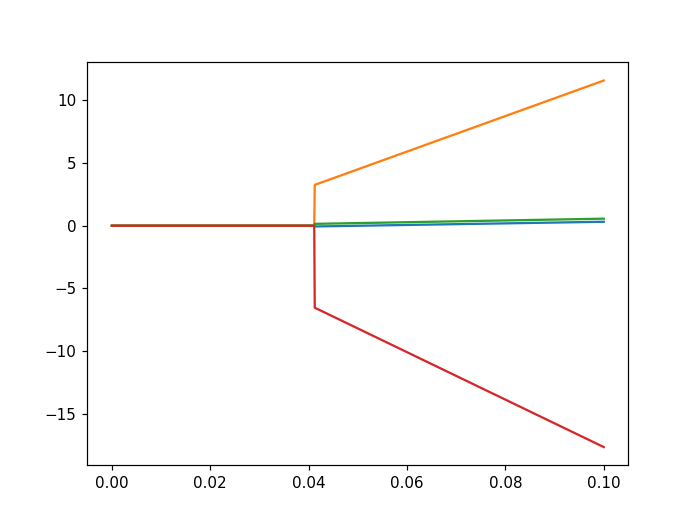

In [41]:
plt.figure()
D0s = np.linspace(0, D0_max, D0_steps)

for i in range(len(I)):
    plt.plot(D0s, I[i], '-')